In [57]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

import tensorflow as tf
import keras

Using TensorFlow backend.


In [58]:
pd.options.display.max_rows = 1000

In [59]:
df = pd.read_csv('./data/train.csv')

In [122]:
def parse_sentence(sentence):
    prev_word, prev_pos = '', ''
    nouns = []
    words = []
    etc = []
    buff = ''
    ret = []
    condition = False
    idx, condidx = 0, 0
    
    if sentence[:4] == '(광고)':
        words.append('(광고)')
        nouns.append('(광고)')
        sentence = sentence[4:]

    for word, pos in mecab.pos(sentence):

        if pos in ('SF') or pos[:1] in ('J'):
            # 은/는/이/가/. 등
            prev_word, prev_pos = '', ''
            continue

        if pos[:1] == 'N' and prev_pos[:1] == 'S':
            # 1억, 1천만원 등
            word = re.sub('[억천만]', '', word)
            if len(word) == 0:
                continue

        if pos[:1] == 'S':
            word = re.sub('[(:)]', '', word)
            word = re.sub('[0-9.X]+', 'X', word)

        # 조건절 판단
        if prev_pos[-3:] == 'ETM' and word in ['분','고객','개인','사업자','이','대상','당신','직원','VIP', '자','분도','전문직','신용자','외국인','본인','임직원','부모','회계사','귀하','투자자','분과']:
            condition = True  
        elif pos[:1] == 'N':
            if word[:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
        elif pos[-2:] == 'EC':
            # 여도, 라도, 라면, 면
            if word[-1:] in ('면', '도') or word[-2:] in ('도록'):
                condition = True

        if pos[:1] == 'E':
            buff += word
        #elif pos[:1] == 'N' and prev_pos[:1] == 'N' and len(word) == 1:
        #    buff += word
        elif pos[:1] == 'S' and prev_pos[:1] == 'S' and word[:1] in 'X0123456789%.-': #('%', '.', '-'):
            if buff[-1:] in ('시', '원', '%'):
                words.append(buff)
                buff = ''
            buff += word
            #buff += re.sub('[0-9.X]+', 'X', word)
            #buff = re.sub('[0-9.X]+', 'X', buff)
        elif pos[:1] == 'N' and prev_pos[:1] == 'S' and len(buff) > 0 and word in ('시', '분', '초', '시간'):
            buff = re.sub('시', '', buff)
            buff += '시'
        elif pos[:1] == 'N' and prev_pos[:1] == 'S' and len(buff) > 0 and word in ('년', '월', '일', '개월'):
            buff = re.sub('일', '', buff)
            buff += '일'
        elif pos[:1] == 'N' and prev_pos[:1] == 'S' and len(buff) > 0 and word in ('원'):
            buff = re.sub('원', '', buff)
            buff += '원'
        elif pos[:1] == 'N' and prev_pos[:1] == 'S' and len(buff) > 0 and word in ('건', '배', 'pt'):
            buff += word
        else:
            if len(buff) > 0:
                buff = re.sub('[0-9.X]+', 'X', buff)
                buff = re.sub('[-]+', '-', buff)
                buff = re.sub('[X]+', 'X', buff)
                if buff != 'X':
                    words.append(buff)
                    # M, N 경우만 저장해보자
                    if prev_pos[:1] in ('N'):  # 'M', 
                        nouns.append(buff)
            buff = word
            prev_word, prev_pos = word, pos

        if pos[-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            # words가 꼭 명사를 뜻하는 게 아니고 특색있는 키워드 모두를 포함
            if len(buff) > 0:
                words.append(buff)
            buff = ''
            ret.append([word, condition, words, nouns])
            idx += 1
            if condition: condidx += 1
            nouns = []
            words = []
            condition = False
    if len(buff) > 0:
        words.append(buff)
    if len(words) > 0:
        ret.append([word, condition, words, nouns])
        #ret.append([word, condition, nouns])
        idx += 1
        if condition: condidx += 1
    etc.append(condidx / idx)
    return ret, etc

In [123]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited, etc = parse_sentence(item.text)
    etc.append(np.log(len(item.text))/8)  # 문장 전체의 길이
    etc.append(np.log(len(splited))/4)  # 문장의 개수
    splited.append(etc)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2020-01-05 19:21:33.978035 0
2020-01-05 19:22:41.951549 100000
2020-01-05 19:23:59.941757 200000


In [124]:
[print(x) for x in smishings[3]]

['세요', False, ['(광고)', '안녕', '하세요'], ['(광고)', '안녕']]
['습니다', True, ['수신', '희망', '하지', '않으실', '경우', '거부', '라는', '답장', '주시면', 'KISA', '수신', '거부', '목록', '등록', '시켜', '두', '번', '다시', '발송', '되지', '않도록', '조치', '취해', '드리겠습니다'], ['수신', '희망', '경우', '거부', '답장', '수신', '거부', '목록', '등록', '번', '발송', '조치']]
['습니다', False, ['추가', '자금', '이나', '채무', '통합', '상담', '안내', '문자', '발송', '하였습니다'], ['추가', '자금', '이나', '채무', '통합', '상담', '안내', '문자', '발송']]
['깁니다', True, ['X-X-X', '담당', '팀장', '매우', '바쁘신', '줄', '알지만', 'X시', '시간', '내주셔서', '저', '글', '끝', '읽어', '주시면', '조금', '도움', '되실', '거', '라', '판단', '되어', '감히', '글', '남깁니다'], ['담당', '팀장', '줄', 'X시', '시간', '저', '글', '끝', '조금', '도움', '거', '판단', '글']]
['입니다', False, ['일전', '금융', '상담', '해', '드렸던', '입니다'], ['일전', '금융', '상담']]
['습니다', False, ['이런', '연락', '들', '하루', '몇', '번', '씩', '받으실', '텐데', '저', '거들게', '되어', '깊은', '사과', '말씀', '드리겠습니다'], ['연락', '들', '하루', '번', '텐데', '저', '사과', '말씀']]
['습니다', False, ['다름', '아니라', '이번', '대출', '전문', '컨설팅', '회사', '이직', '했습니다'], ['다름', '이번', '대출',

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [125]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [126]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')

for normal in normals:
    for item in normal[:-2]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

for smishing in smishings:
    for item in smishing[:-2]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

In [127]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))

# 글자가 2개 이상인 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]  # M,N 만 포함시켰으므로.. 길이 2이상인것만
general_df = general_df[general_df.index.map(len) > 1]

# 3번 이상 출현한 것만 모아보자
#conditioned_df = conditioned_df[conditioned_df.sort_values() > 2]
#general_df = general_df[general_df.sort_values() > 2]

In [128]:
general_dic = general_df[general_df > 1].sort_values(ascending=False)
general_dic = general_dic.reset_index()['index'].to_dict()
general_vocab = {general_dic.get(k):k for k in general_dic}

In [129]:
conditioned_dic = conditioned_df[conditioned_df > 1].sort_values(ascending=False)
conditioned_dic = conditioned_dic.reset_index()['index'].to_dict()
conditioned_vocab = {conditioned_dic.get(k):k for k in conditioned_dic}

In [130]:
# smishing cases; length of vocab when it's out of vocab
tidf_conditioned = []
tidf_general = []
tidf_etc = []

cond_vocabsize = len(conditioned_vocab)
gen_vocabsize = len(general_vocab)

print('size of vocab (conditioned, general):', cond_vocabsize, gen_vocabsize)
for msg in normals:
    tidf_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-2] if row[1] == True for x in row[3]])
    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-2] if row[1] == False for x in row[3]])
#    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-2] for x in row[2]])    
    tidf_etc.append(msg[-2])
for msg in smishings:
    tidf_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-2] if row[1] == True for x in row[3]])
    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-2] if row[1] == False for x in row[3]])
#    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-2] for x in row[2]])
    tidf_etc.append(msg[-2])

size of vocab (conditioned, general): 18476 31524


In [131]:
len(tidf_conditioned), len(tidf_general), len(tidf_etc)

(295945, 295945, 295945)

In [132]:
convec_size = max(max([len(x) for x in tidf_conditioned]), max([len(x) for x in tidf_conditioned]))
genvec_size = max(max([len(x) for x in tidf_general]), max([len(x) for x in tidf_general]))

# 문장 내 인식한 단어의 개수의 최대값 (문장의 길이가 길수록 크겠지..)
print('conditioned vector minimum size:', convec_size)
print('general vector minimum size:', genvec_size)

conditioned vector minimum size: 258
general vector minimum size: 333


In [133]:
# 훈련용, 훈련검증용, 결과검증용 분리
tidf_conditioned = np.array(tidf_conditioned)
tidf_general = np.array(tidf_general)
tidf_etc = np.array(tidf_etc)
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

In [134]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, tidf_etc_train, tidf_label_train, normal_size=160, smishing_size=160, convec_size=350, genvec_size=470):
        self.convec_size = convec_size  # including 0 paddings
        self.genvec_size = genvec_size  # including 0 paddings
        self.tidf_cond_train_normal = pad_sequences(tidf_cond_train[tidf_label_train == 0], maxlen=self.convec_size, padding='pre')
        self.tidf_gen_train_normal = pad_sequences(tidf_gen_train[tidf_label_train == 0], maxlen=self.genvec_size, padding='pre')
        self.tidf_etc_train_normal = tidf_etc_train[tidf_label_train == 0]
        self.tidf_cond_train_smishing = pad_sequences(tidf_cond_train[tidf_label_train == 1], maxlen=self.convec_size, padding='pre')
        self.tidf_gen_train_smishing = pad_sequences(tidf_gen_train[tidf_label_train == 1], maxlen=self.genvec_size, padding='pre')
        self.tidf_etc_train_smishing = tidf_etc_train[tidf_label_train == 1]
        self.sample_size_normal = normal_size
        self.sample_size_smishing = smishing_size
        self.train_size_normal = len(self.tidf_cond_train_normal)
        self.train_size_smishing = len(self.tidf_cond_train_smishing)
#         self.sample_size = normal_size + smishing_size
#         self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) // self.sample_size / 10))
        self.num_batch_normal = int(np.ceil(self.train_size_normal / self.sample_size_normal))
        self.num_batch_smishing = int(np.ceil(self.train_size_smishing / self.sample_size_smishing))
        self.normal_train_index = np.array(range(self.train_size_normal))
        self.smishing_train_index = np.array(range(self.train_size_smishing))
        print(f"num_batch_normal: {self.num_batch_normal}, num_batch_smishing: {self.num_batch_smishing}")
    
    def __len__(self):
        return max(self.num_batch_normal, self.num_batch_smishing)
    
    def __getitem__(self, index):
        # sequencial sampling
        normal_idx, smishing_idx = index % self.num_batch_normal, index % self.num_batch_smishing
        #print(f"normal_idx: {normal_idx}, smishing_idx: {smishing_idx}")
        normal_sampling = self.normal_train_index // self.sample_size_normal == normal_idx
#         normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
        normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
        normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        normal_etc_sample = self.tidf_etc_train_normal[normal_sampling]
        smishing_sampling = self.smishing_train_index // self.sample_size_smishing == smishing_idx
#         smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
        smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
        smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        smishing_etc_sample = self.tidf_etc_train_smishing[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_etc_train = np.concatenate([normal_etc_sample, smishing_etc_sample])
        sample_label_train = [1 if x >= len(normal_cond_sample) else 0 for x in range(len(sample_cond_train))]
        return [sample_cond_train, sample_gen_train, sample_etc_train], sample_label_train
#        return [sample_gen_train, sample_etc_train], sample_label_train

    def on_epoch_end(self):
        pass

In [135]:
TRAIN_RATIO, VALID_RATIO = 0.6, 0.8
np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < TRAIN_RATIO]
tidf_cond_valid = tidf_conditioned[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_cond_test = tidf_conditioned[split >= VALID_RATIO]

tidf_gen_train = tidf_general[split < TRAIN_RATIO]
tidf_gen_valid = tidf_general[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_gen_test = tidf_general[split >= VALID_RATIO]

tidf_etc_train = tidf_etc[split < TRAIN_RATIO]
tidf_etc_valid = tidf_etc[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_etc_test = tidf_etc[split >= VALID_RATIO]

tidf_label_train = tidf_label[split < TRAIN_RATIO]
tidf_label_valid = tidf_label[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_label_test = tidf_label[split >= VALID_RATIO]

tidf_cond_train.shape, tidf_cond_valid.shape #, tidf_cond_test.shape

((177533,), (59281,))

In [136]:
num_predictive_factors1, num_predictive_factors2 = 24, 32
n_cond, n_gen, n_etc = convec_size, genvec_size, len(tidf_etc_train[0])
cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')
etc_input = keras.layers.Input(shape=(n_etc,), name='Etc')

cond_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors1, )(cond_input)
cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

# cond_dense = keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l1(0.001), name='FullyConnected-Cond')(cond_vec_mlp)
# cond_dropout = keras.layers.Dropout(0.3, name='Dropout-Cond')(cond_dense)

gen_vec_mlp = keras.layers.Embedding(gen_vocabsize + 1, num_predictive_factors2, )(gen_input)
gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

# gen_dense = keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l1(0.001), name='FullyConnected-Gen')(gen_vec_mlp)
# gen_dropout = keras.layers.Dropout(0.3, name='Dropout-Gen')(gen_dense)

concat_mlp = keras.layers.merge.concatenate([cond_vec_mlp, gen_vec_mlp, etc_input]) # , etc_input
concat_dropout_mlp = keras.layers.Dropout(0.3)(concat_mlp)

dense = keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-1', activation='relu')(concat_dropout_mlp)
dropout_1 = keras.layers.Dropout(0.3, name='Dropout-1')(dense)

#dense_2 = keras.layers.Dense(DENSE2, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-2', activation='relu')(dropout_1)
#dropout_2 = keras.layers.Dropout(0.3, name='Dropout-2')(dense_2)

#dense_3 = keras.layers.Dense(DENSE3, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-3', activation='relu')(dropout_2)
#dropout_3 = keras.layers.Dropout(0.3, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-4', activation='relu')(dropout_1)
pred_mlp = keras.layers.Dense(1, activation='sigmoid', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input, etc_input ], output=pred_mlp)  #  etc_input
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
#model.compile(optimizer=keras.optimizers.Adamax(lr=1e-3), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])

/home/xikizima/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [141]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, tidf_etc_train, tidf_label_train, 160, 160, convec_size, genvec_size)
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, tidf_etc_valid, tidf_label_valid, 1000, 1000, convec_size, genvec_size)

history = model.fit_generator(generator=train_gen,
                             epochs = 20,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch_normal: 1039, num_batch_smishing: 71
num_batch_normal: 56, num_batch_smishing: 4
Epoch 1/20
1039/1039 [==============================] - 168s 162ms/step - loss: 0.0060 - binary_crossentropy: 0.0019 - acc: 0.9997 - val_loss: 0.0106 - val_binary_crossentropy: 0.0065 - val_acc: 0.9987
Epoch 2/20
1039/1039 [==============================] - 169s 162ms/step - loss: 0.0053 - binary_crossentropy: 0.0016 - acc: 0.9998 - val_loss: 0.0098 - val_binary_crossentropy: 0.0062 - val_acc: 0.9986
Epoch 3/20
1039/1039 [==============================] - 168s 162ms/step - loss: 0.0049 - binary_crossentropy: 0.0015 - acc: 0.9998 - val_loss: 0.0097 - val_binary_crossentropy: 0.0065 - val_acc: 0.9986
Epoch 4/20
1039/1039 [==============================] - 167s 161ms/step - loss: 0.0046 - binary_crossentropy: 0.0015 - acc: 0.9998 - val_loss: 0.0097 - val_binary_crossentropy: 0.0067 - val_acc: 0.9985
Epoch 5/20
1039/1039 [==============================] - 167s 161ms/step - loss: 0.0043 - binary_cross

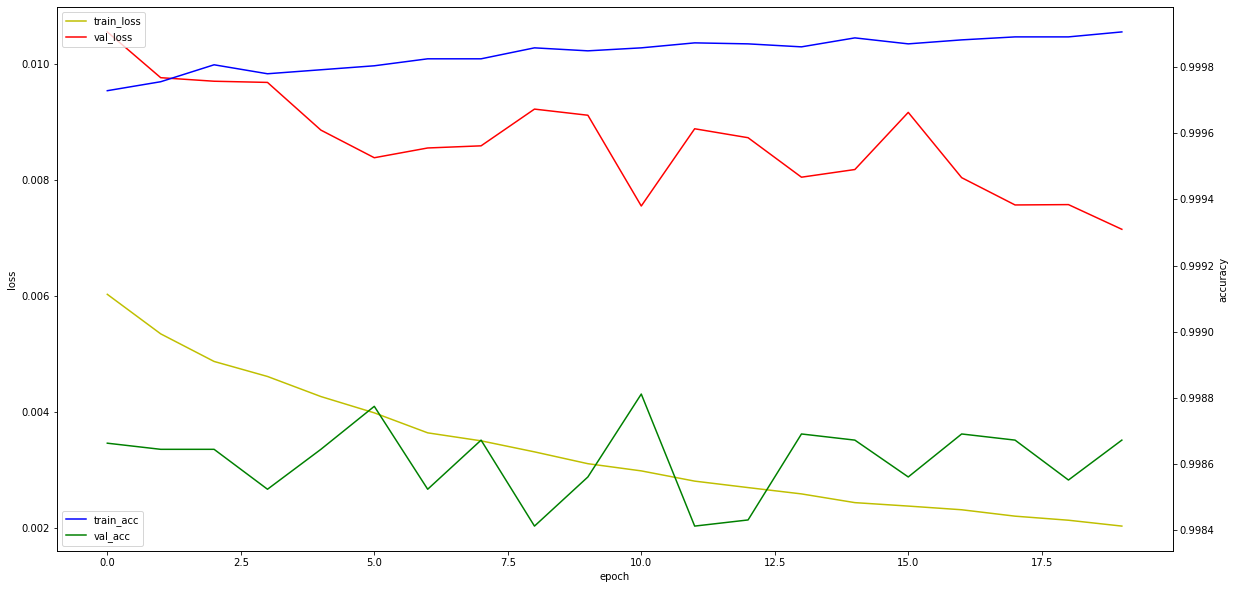

In [142]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [243]:
data_gen_train = pad_sequences(tidf_gen_train, maxlen=genvec_size, padding='pre')
data_cond_train = pad_sequences(tidf_cond_train, maxlen=convec_size, padding='pre')
data_gen_valid = pad_sequences(tidf_gen_valid, maxlen=genvec_size, padding='pre')
data_cond_valid = pad_sequences(tidf_cond_valid, maxlen=convec_size, padding='pre')

In [ ]:
*_, train_acc = model.evaluate([data_cond_train, data_gen_train], tidf_label_train)
*_, valid_acc = model.evaluate([data_cond_valid, data_gen_valid], tidf_label_valid)
train_acc, valid_acc, '{:.3f}%'.format(valid_acc / train_acc * 100)

In [139]:
data_gen_test = pad_sequences(tidf_gen_test, maxlen=genvec_size, padding='pre')
data_cond_test = pad_sequences(tidf_cond_test, maxlen=convec_size, padding='pre')
data_etc_test = tidf_etc_test

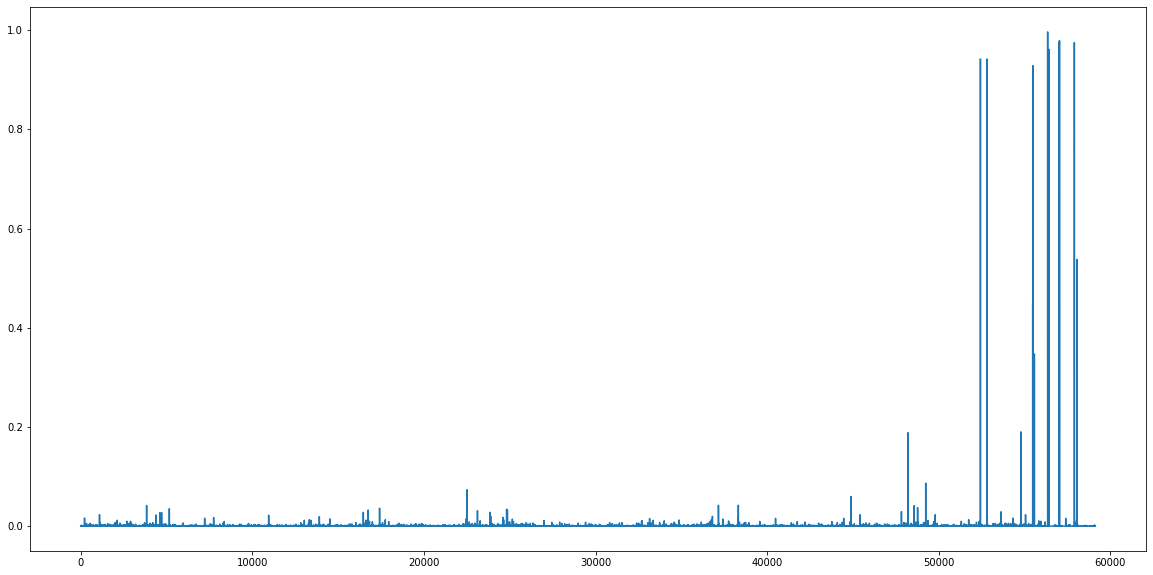

In [143]:
# 30 trained
pred_test = model.predict(x=[data_cond_test, data_gen_test, data_etc_test], batch_size=160)
gap = np.abs(tidf_label_test - pred_test.reshape([-1,]))

plt.figure(figsize=(20,10))
plt.plot(gap)

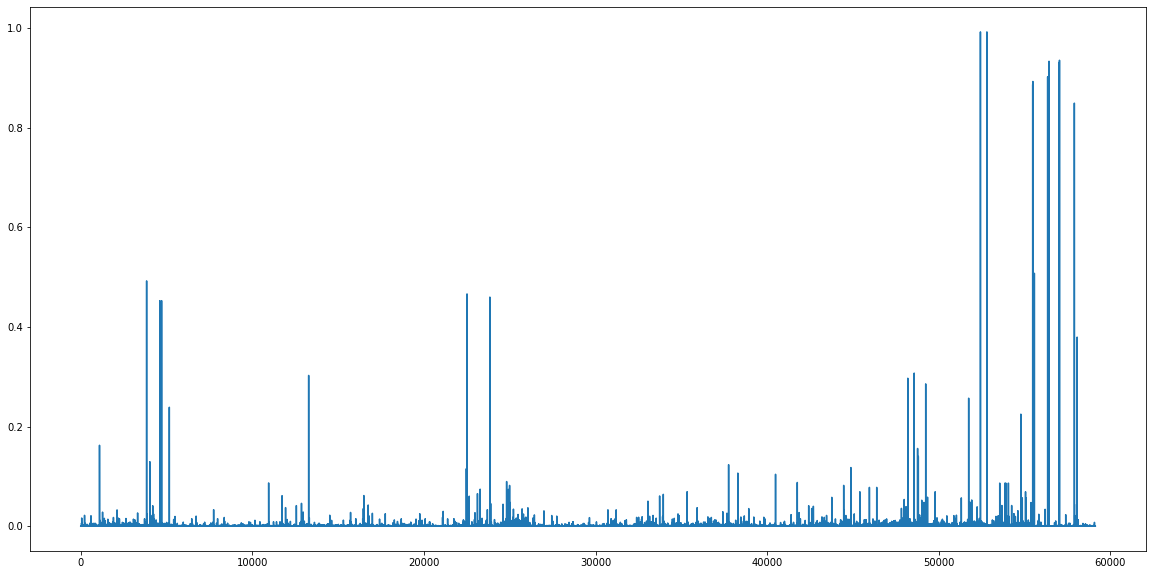

In [140]:
# 10 trained
pred_test = model.predict(x=[data_cond_test, data_gen_test, data_etc_test], batch_size=160)
gap = np.abs(tidf_label_test - pred_test.reshape([-1,]))

plt.figure(figsize=(20,10))
plt.plot(gap)

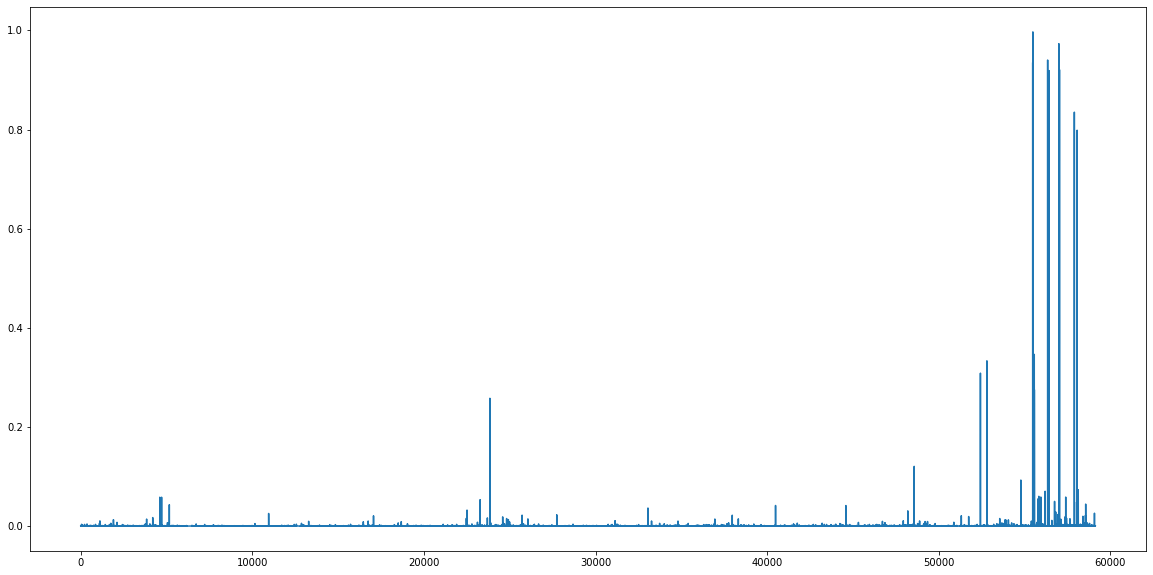

In [262]:
# test
pred_test = model.predict(x=[data_cond_test, data_gen_test, data_etc_test], batch_size=160)
gap = np.abs(tidf_label_test - pred_test.reshape([-1,]))

plt.figure(figsize=(20,10))
plt.plot(gap)

In [ ]:
# 제출 준비

In [145]:
submit_df = pd.read_csv('./data/public_test.csv')

In [146]:
unknowns = []

idx = 0
for idx, item in submit_df.iterrows():
    splited, etc = parse_sentence(item.text)
    etc.append(np.log(len(item.text))/8)  # 문장 전체의 길이
    etc.append(np.log(len(splited))/4)  # 문장의 개수
    splited.append(etc)
    splited.append(item.id)
    unknowns.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1

2020-01-05 20:55:23.359392 0


In [148]:
# smishing cases; length of vocab when it's out of vocab
submit_conditioned = []
submit_general = []
submit_etc = []

cond_vocabsize = len(conditioned_vocab)
gen_vocabsize = len(general_vocab)

print('size of vocab (conditioned, general):', cond_vocabsize, gen_vocabsize)
for msg in unknowns:
    submit_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-2] if row[1] == True for x in row[3]])
    submit_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-2] if row[1] == False for x in row[3]])
#    submit_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-2] for x in row[2]])
    submit_etc.append(msg[-2])

size of vocab (conditioned, general): 18476 31524


In [149]:
data_submit_conditioned = pad_sequences(submit_conditioned, maxlen=convec_size, padding='pre')
data_submit_general = pad_sequences(submit_general, maxlen=genvec_size, padding='pre')
data_submit_etc = np.array(submit_etc)

In [150]:
pred_y = model.predict(x=[data_submit_conditioned, data_submit_general, data_submit_etc], verbose=1)

1626/1626 [==============================] - 0s 89us/step


In [151]:
pred_y[pred_y > 1.0] = 1.0

In [152]:
submit_df['smishing'] = np.abs(pred_y)

In [153]:
submit_df[['id', 'smishing']].to_csv('./data/submission_20200105_2.csv', index=False)

In [ ]:
# 컨디션 문장의 경우.. 명사만 가지고 만들까?.. 의 컨셉
# 0.962889 기록 (2020.01.04 23:50)